# What I need to do


1. Find all useful files for both matrix scaling and core scaling

2. Start with matrix scaling
   
   a. Get rid of "Measurement" columnn by averaging the various measurements of the file
   
   b. Average multiple files for same experiment
   
   c. Obtain in this way a single file per experiment, with columns: 
   
   d. Create a separate plots for each file and then group together some plots

3. Do core scaling
   
   a. do steps like above


# TO DO

- distinguish between initialized version and not initialized version
- understand what went wrong

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from enum import Enum
import csv
import pandas as pd
import os
import tempfile

In [40]:
def remove_whitespace_in_csv(file_path):
    # Create a temporary file to write the cleaned data
    temp_file = tempfile.NamedTemporaryFile(mode="w", delete=False, newline="")

    with open(file_path, "r", newline="") as infile, temp_file:
        reader = csv.reader(infile)
        writer = csv.writer(temp_file)

        for row in reader:
            cleaned_row = [item.strip() for item in row]
            writer.writerow(cleaned_row)

    # Replace the original file with the cleaned file
    os.replace(temp_file.name, file_path)

In [22]:
def list_files(startpath):
    matrix_files = []
    core_files = []
    slurm_files = []

    # Puts file names in lists of matrix, core or slurm files based on name (not very robust)
    for root, dirs, files in os.walk(startpath):
        for file in files:
            if "matrx" in file:
                matrix_files.append(os.path.join(root, file))
            elif "core" in file:
                core_files.append(os.path.join(root, file))
            elif "slurm" in file:
                slurm_files.append(os.path.join(root, file))

    return matrix_files, core_files, slurm_files

In [23]:
matrix_files, core_files, slurm_files = list_files("outputs")

In [42]:
core_files


['outputs/core_scaling/mkl-core-scaling-809752-init.csv',
 'outputs/core_scaling/oblas-core-scaling-809384.csv',
 'outputs/core_scaling/blis-core-scaling-809750-init.csv',
 'outputs/core_scaling/oblas-core-scaling-809543.csv',
 'outputs/core_scaling/blis-core-scaling-809383.csv',
 'outputs/core_scaling/mkl-core-scaling-809385.csv',
 'outputs/core_scaling/mkl-core-scaling-809542.csv',
 'outputs/core_scaling/oblas-core-scaling-809751-init.csv',
 'outputs/core_scaling/blis-core-scaling-809544.csv',
 'outputs/core_scaling/blis-core-scaling-809381.csv']

In [43]:
matrix_files

['outputs/matrix_scaling/mkl-matrx-scaling-809747-init.csv',
 'outputs/matrix_scaling/mkl-matrx-scaling-809722.csv',
 'outputs/matrix_scaling/blis-matrx-scaling-809749-init.csv',
 'outputs/matrix_scaling/blis-matrx-scaling-809720.csv',
 'outputs/matrix_scaling/blis-matrx-scaling-809563.csv',
 'outputs/matrix_scaling/mkl-matrx-scaling-809565.csv',
 'outputs/matrix_scaling/oblas-matrx-scaling-809721.csv',
 'outputs/matrix_scaling/oblas-matrx-scaling-809748-init.csv',
 'outputs/matrix_scaling/oblas-matrx-scaling-809564.csv']

In [44]:
for file in core_files:
    remove_whitespace_in_csv(file)
for file in matrix_files:
    remove_whitespace_in_csv(file)

In [45]:
def df_average_measurements(file):
    if "core" in file:
        cols = ['Number of CPUs', 'Precision', 'Bind']
    elif "matrix" in file:
        cols = ['Matrix Size (n)', 'Precision', 'Bind']
    else:
        print("Could not understand what the file is about")
        return

    df = pd.DataFrame(pd.read_csv(file))
    df = df.groupby(cols, as_index=False).mean()
    df.drop(columns=['Measurement'], inplace=True)
    df = df.sort_values(by=['Bind'])
    return df


def df_average_experiments(library, exp, dir):
    if library not in ["blis", "oblas", "mkl"]:
        print("Invalid library")
        return
    matrix_files, core_files, _ = list_files(dir)
    if exp == "matrix":
        files = matrix_files
        cols = ["Matrix Size (n)", "Precision", "Bind"]
        sort_col = "Matrix Size (n)"
    elif exp == "core":
        files = core_files
        cols = ["Number of CPUs", "Precision", "Bind"]
        sort_col = "Number of CPUs"
    else:
        print("Invalid experiment type")
        return
    files = [file for file in files if library in file]

    if len(files) == 0:
        print("No useful files found")
        return
    df_list = [pd.read_csv(file) for file in files]
    df = pd.concat(df_list, ignore_index=True)
    df["Bind"] = df["Bind"].astype("category")

    df = df.groupby(cols, as_index=False).mean()

    df = df.sort_values(by=[sort_col])
    if "Measurement" in df.columns:
        df.drop(columns=["Measurement"], inplace=True)

    return df

/tmp/ipykernel_140792/529264584.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(cols, as_index=False).mean()


- Get sub df where bind==spread
- Keep only "Number of CPUs" and "GFLOPS"


In [62]:
dfs = []
for lib in ["blis", "oblas", "mkl"]:
    spread_df = df_average_experiments(lib, "core", "outputs")
    spread_df.drop(columns=["Seconds"], inplace=True)

    # Pivot the DataFrame with multi-level columns including 'Bind'
    spread_df_pivoted = spread_df.pivot(
        index=["Number of CPUs"], columns=["Bind", "Precision"], values="GFLOPS"
    ).reset_index()

    # Flatten the multi-level columns
    spread_df_pivoted.columns = [
        " ".join(col).strip() if isinstance(col, tuple) else col
        for col in spread_df_pivoted.columns
    ]

    # Add a column with the library name
    spread_df_pivoted["Library"] = lib

    # Append the processed DataFrame to the list
    dfs.append(spread_df_pivoted)

    del spread_df
    # Rename the columns for clarity (if necessary)
    spread_df_pivoted.columns.name = None  # Remove the column grouping name
    spread_df_pivoted.rename(columns={'Single': 'Single GFLOPS', 'Double': 'Double GFLOPS'}, inplace=True)

full_core_scaling_df = pd.concat(dfs, ignore_index=True)

    Number of CPUs  spread Single  close Single  spread Double  close Double  \
0                1      83.972069     83.952817      40.199606     40.179597   
1                2     158.783411    158.714844      76.582384     76.566335   
2                3     239.779941    239.953312     115.286145    115.484265   
3                4     321.912843    321.734486     146.206457    146.154243   
4                5     407.120227    407.070186     179.822513    179.674681   
..             ...            ...           ...            ...           ...   
67              20    2612.155993   2611.161714    1329.554840   1329.148842   
68              21    2734.921889   2738.579901    1400.169933   1399.593870   
69              22    2853.715513   2855.868073    1458.802118   1458.704711   
70              23    2973.133551   2972.336049    1518.533275   1518.476598   
71              24    3088.816118   3089.914629    1578.016763   1578.676305   

   Library  
0     blis  
1     blis  


/tmp/ipykernel_140792/529264584.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(cols, as_index=False).mean()
/tmp/ipykernel_140792/529264584.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(cols, as_index=False).mean()
/tmp/ipykernel_140792/529264584.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(cols, as_index=False).mean()


/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

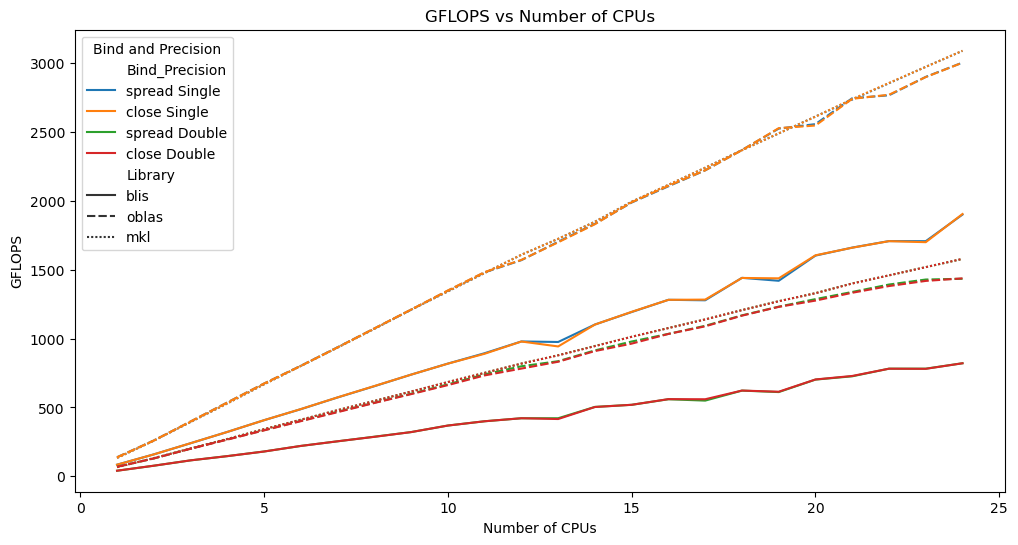

In [63]:
# Melt the DataFrame
melted_df = full_core_scaling_df.melt(
    id_vars=["Number of CPUs", "Library"],
    var_name="Bind_Precision",
    value_name="GFLOPS",
)

# Plot using sns.lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=melted_df,
    x="Number of CPUs",
    y="GFLOPS",
    hue="Bind_Precision",
    style="Library",
)
plt.title("GFLOPS vs Number of CPUs")
plt.xlabel("Number of CPUs")
plt.ylabel("GFLOPS")
plt.legend(title="Bind and Precision")
plt.show()

/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

<Axes: xlabel='Number of CPUs', ylabel='Single GFLOPS'>

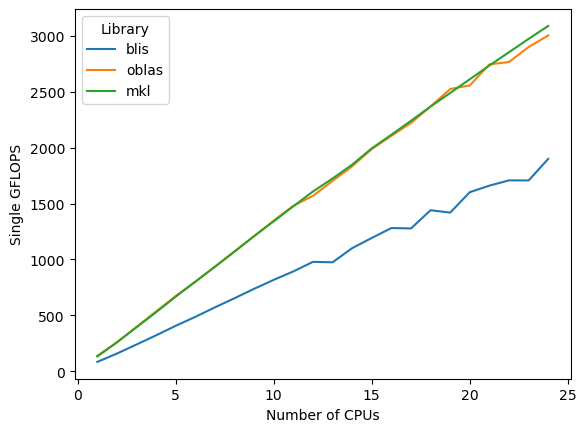

In [59]:
sns.lineplot(
    x="Number of CPUs",
    y="Single GFLOPS",
    data=full_core_scaling_df,
    hue="Library",
    errorbar=None,
)

/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

<Axes: xlabel='Number of CPUs', ylabel='Double GFLOPS'>

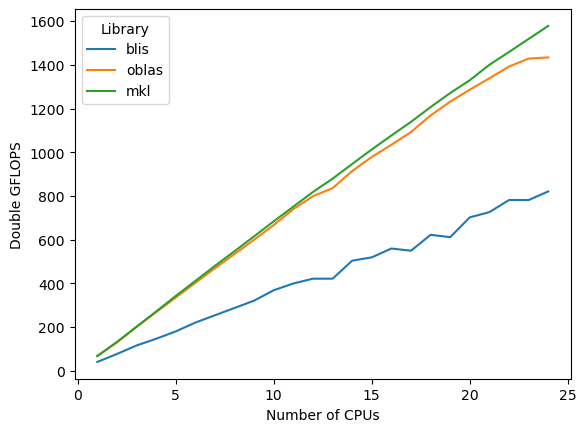

In [60]:
sns.lineplot(
    x="Number of CPUs",
    y="Double GFLOPS",
    data=full_core_scaling_df,
    hue="Library",
    errorbar=None,
)

## Matrix scaling

/tmp/ipykernel_140792/529264584.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(cols, as_index=False).mean()
/tmp/ipykernel_140792/529264584.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(cols, as_index=False).mean()
/tmp/ipykernel_140792/529264584.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(cols, as_index=False).mean()
/home/pettepiero/local/envs/viz/li

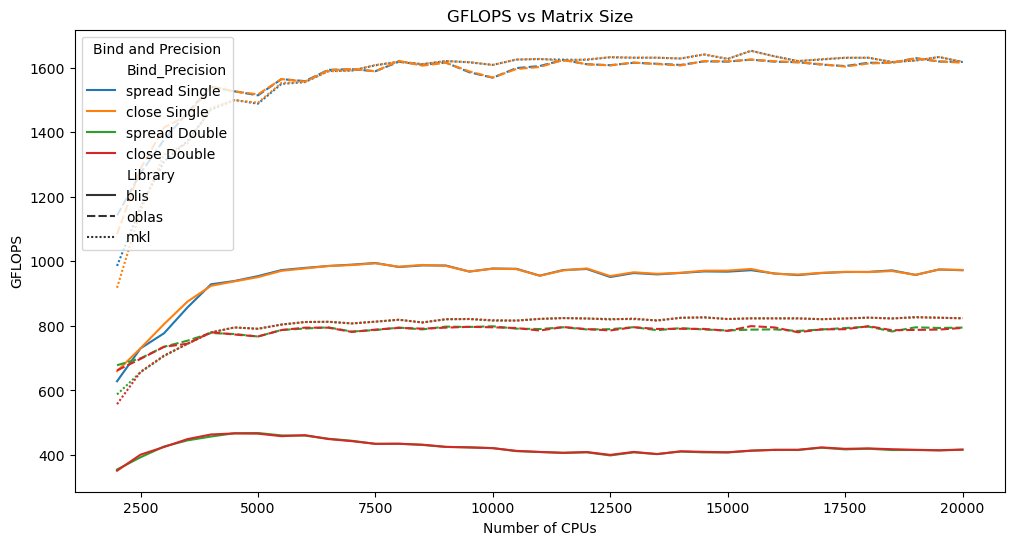

In [66]:
dfs = []
for lib in ["blis", "oblas", "mkl"]:
    spread_df = df_average_experiments(lib, "matrix", "outputs")
    spread_df.drop(columns=["Seconds"], inplace=True)

    # Pivot the DataFrame with multi-level columns including 'Bind'
    spread_df_pivoted = spread_df.pivot(
        index=["Matrix Size (n)"], columns=["Bind", "Precision"], values="GFLOPS"
    ).reset_index()

    # Flatten the multi-level columns
    spread_df_pivoted.columns = [
        " ".join(col).strip() if isinstance(col, tuple) else col
        for col in spread_df_pivoted.columns
    ]

    # Add a column with the library name
    spread_df_pivoted["Library"] = lib

    # Append the processed DataFrame to the list
    dfs.append(spread_df_pivoted)

    del spread_df
    # Rename the columns for clarity (if necessary)
    spread_df_pivoted.columns.name = None  # Remove the column grouping name
    spread_df_pivoted.rename(
        columns={"Single": "Single GFLOPS", "Double": "Double GFLOPS"}, inplace=True
    )

full_core_scaling_df = pd.concat(dfs, ignore_index=True)

# Melt the DataFrame
melted_df = full_core_scaling_df.melt(
    id_vars=["Matrix Size (n)", "Library"],
    var_name="Bind_Precision",
    value_name="GFLOPS",
)

# Plot using sns.lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=melted_df,
    x="Matrix Size (n)",
    y="GFLOPS",
    hue="Bind_Precision",
    style="Library",
)
plt.title("GFLOPS vs Matrix Size")
plt.xlabel("Number of CPUs")
plt.ylabel("GFLOPS")
plt.legend(title="Bind and Precision")
plt.show()

['mkl-matrx-scaling-809461.csv', 'mkl-matrx-scaling-809403.csv']


In [ ]:
# Function that averages files and merges them into a single file for each lib for each precision
def merge_files_by_library(folder):

    for lib in ["blis", "oblas", "mkl"]:
        files = get_files_lib(lib, folder)
        print(f"Current library: {lib}")
        print(f"Files: {files}")

        for bind in ["close", "spread"]:
            print(f"Current bind: {bind}")

            for precision in ["Single", "Double"]:
                print(f"Current precision: {precision}")

                seconds = None
                gflops = None        

                for file in files:
                    print(f"Current file: {file}")
                    df = pd.DataFrame(pd.read_csv(os.path.join(folder, file)))
                    print(df.head())
                    df = df[df["Precision"] == precision]
                    df = df[df["Bind"] == bind]

                    if seconds is None:
                        seconds = df.loc[:, "Seconds"]
                    else:
                        seconds = seconds.add(df.loc[:, "Seconds"], fill_value=0)

                    if gflops is None:
                        gflops = df.loc[:, "GFLOPS"]
                    else:
                        gflops = gflops.add(df.loc[:, "GFLOPS"], fill_value=0)

                seconds = seconds.div(len(files))
                gflops = gflops.div(len(files))

                average_df = pd.DataFrame(
                        {
                            "Matrix Size (n)": df["Matrix Size (n)"],
                            "Seconds": seconds,
                            "GFLOPS": gflops
                        }
                    )
                os.makedirs("./csv-outputs", exist_ok=True)
                filename = f"./csv-outputs/{lib}-{precision}-{bind}.csv"
                average_df.to_csv(filename, index=False)

In [ ]:
merge_files_by_library("outputs/matrix_scaling")

Current library: blis
Files: ['blis-matrx-scaling-809401.csv', 'blis-matrx-scaling-809460.csv']
Current bind: close
Current precision: Single
Current file: blis-matrx-scaling-809401.csv
   Matrix Size (n)   Seconds      GFLOPS Precision   Bind
0             2000  0.021055  759.909709    Single  close
Current file: blis-matrx-scaling-809460.csv
   Matrix Size (n)   Seconds      GFLOPS Precision   Bind
0             2000  0.021023  761.074792    Single  close
Current precision: Double
Current file: blis-matrx-scaling-809401.csv
   Matrix Size (n)   Seconds      GFLOPS Precision   Bind
0             2000  0.021055  759.909709    Single  close
Current file: blis-matrx-scaling-809460.csv
   Matrix Size (n)   Seconds      GFLOPS Precision   Bind
0             2000  0.021023  761.074792    Single  close
Current bind: spread
Current precision: Single
Current file: blis-matrx-scaling-809401.csv
   Matrix Size (n)   Seconds      GFLOPS Precision   Bind
0             2000  0.021055  759.909709   

In [ ]:
# Lists to store extracted data
matrix_dimensions = []
mkl_gflops = []
OBLAS_gflops = []
blis_gflops = []
output_folder = 'csv-outputs/'
class libName(Enum):
    MKL = 'mkl'
    OBLAS = 'oblas'
    BLIS = 'blis'

delete_old_csv()

# Function to select the library based on the file name
def select_library(fileName):
    if 'mkl' in fileName:
        selected_library = libName.MKL
    elif 'oblas' in fileName:
        selected_library = libName.OBLAS
    elif 'blis' in fileName:
        selected_library = libName.BLIS
    else:
        print(f"Error, {fileName} doesn't contain 'mkl' or 'oblas'. This will produce unkown output.")
    print(f"Selected library is '{selected_library.name}'.")
    return selected_library

# Function to create lists of data from the files
def create_lists(folder, lib_names):
    matrix_files, core_files, _ = list_files(folder)

    print(f"Matrix files:")
    for fileName in matrix_files:
        print(f"Reading file '{fileName}'.\n")
        if os.path.isfile(fileName):
            selected_library = select_library(fileName)
        else:
            print(f"Error, file '{fileName}' is not a file.")
            continue

        data = []
        # Read the text file line by line
        with open(fileName, 'r') as input_file:
            lines = input_file.readlines()
            for line in lines[1:]:  # Skip the first line
                print(f"line = {line}")
                # Assuming each line contains two values separated by a space
                size, seconds, gflops, precision, bind = line.strip().split(sep=',')
                data.append([size, gflops])
            # Construct the output CSV file name using the prefix and a desired extension
            print(str(selected_library.name))
            output_file_name = output_folder + str(selected_library.name) + "-output.csv"

            # Append data to the CSV file. This allows data from more than one execution to be added to the same csv file.
            with open(output_file_name, 'a', newline='') as output_file:
                csv_writer = csv.writer(output_file)
                csv_writer.writerow(['Size', 'GFLOPs'])  # Write header
                csv_writer.writerows(data)  # Write data rows

            print(f"CSV file '{output_file_name}' created.")

Deleted: csv-outputs/MKL-output.csv
Deleted: csv-outputs/BLIS-output.csv
Deleted: csv-outputs/OBLAS-output.csv
All files in 'csv-outputs/' have been deleted.


In [ ]:
create_lists('outputs', libName)

Matrix files:
Reading file 'outputs/matrix_scaling/blis-matrx-scaling-809401.csv'.

Selected library is 'BLIS'.
line = 2000, 0.021055, 759.909709,Single,close

BLIS
CSV file 'csv-outputs/BLIS-output.csv' created.
Reading file 'outputs/matrix_scaling/mkl-matrx-scaling-809461.csv'.

Selected library is 'MKL'.
line = 2000, 0.408368, 39.180383,Single,close

line = 2000, 0.108955, 146.849324,Double,close

line = 2500, 0.025564, 1222.425790,Single,close

line = 2500, 0.044172, 707.459386,Double,close

line = 3000, 0.038162, 1415.015876,Single,close

line = 3000, 0.069888, 772.670109,Double,close

line = 3500, 0.057718, 1485.660517,Single,close

line = 3500, 0.105775, 810.683981,Double,close

line = 4000, 0.079224, 1615.679891,Single,close

line = 4000, 0.146875, 871.490970,Double,close

line = 4500, 0.109094, 1670.573548,Single,close

line = 4500, 0.201856, 902.870075,Double,close

line = 5000, 0.151715, 1647.830427,Single,close

line = 5000, 0.282260, 885.708686,Double,close

line = 5500, 0

/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/viz/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

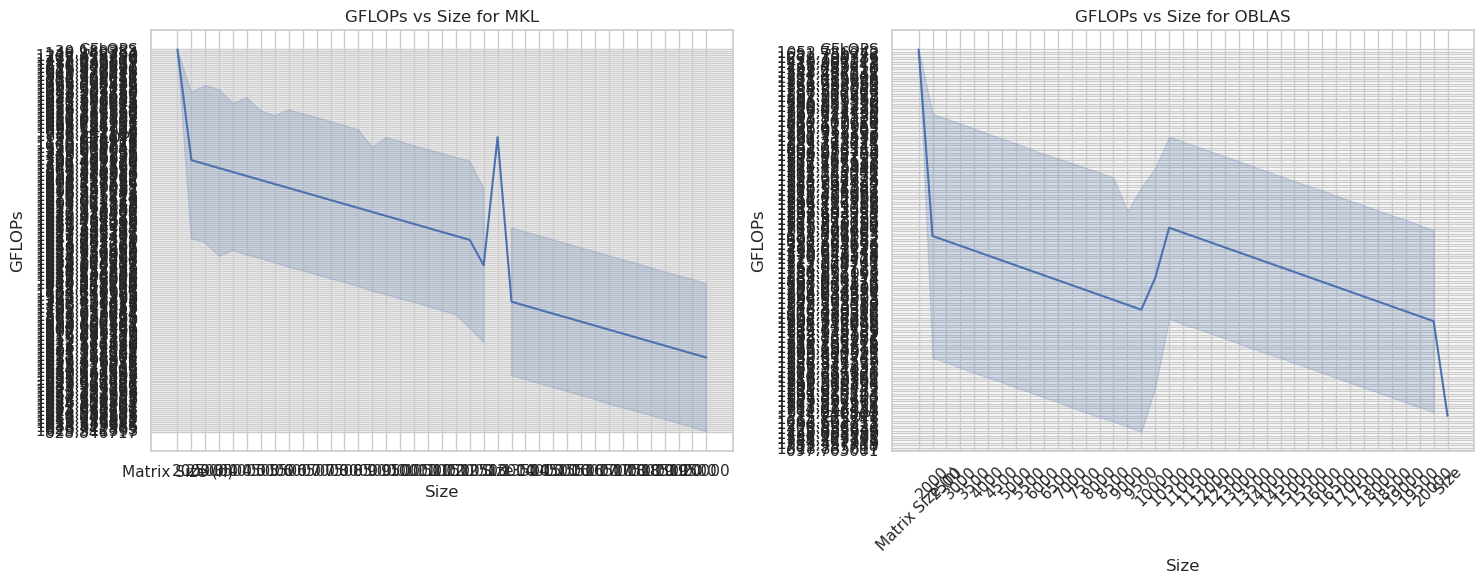

In [ ]:
# Load CSV data
csv_file_path = 'csv-outputs/MKL-output.csv'
data = pd.read_csv(csv_file_path)

# Create the plot using Seaborn
sns.set(style="whitegrid")  # Set style for the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create a 1x2 grid of subplots

#Plotting MKL-outputs
sns.lineplot(x='Size', y='GFLOPs', data=data, ax=axes[0])

axes[0].set_xlabel("Size")
axes[0].set_ylabel("GFLOPs")
axes[0].set_title("GFLOPs vs Size for MKL")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

#Plotting OBLAS-outputs
csv_file_path = 'csv-outputs/OBLAS-output.csv'
data = pd.read_csv(csv_file_path)
sns.lineplot(x='Size', y='GFLOPs', data=data, ax=axes[1])

axes[1].set_xlabel("Size")
axes[1].set_ylabel("GFLOPs")
axes[1].set_title("GFLOPs vs Size for OBLAS")

# Saving image as jpg
plt.savefig("images/matrx-scaling.jpg", dpi=300)

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()  # Adjust layout for better appearance
plt.show()  # Show the plot



In [ ]:
# Lists to store extracted data
matrix_dimensions = []
mkl_gflops = []
OBLAS_gflops = []


# Read the text file line by line
with open('mkl-core-scaling', 'r') as file:
    for line in file:
        # Split line into words
        words = line.strip().split()

        # Extract x value (first number until 'x')
        value = float(words[0].split('x')[0])
        matrix_dimensions.append(value)

        # Extract y value (second-to-last word)
        gflop = int(round(float(words[-2])))
        mkl_gflops.append(int(gflop))


# # Read the text file line by line
with open('oblas-core-scaling', 'r') as file:
    for line in file:
        # Split line into words
        words = line.strip().split()

        # Extract y value (second-to-last word)
        gflop = int(round(float(words[-2])))
        OBLAS_gflops.append(int(gflop))


print(type(mkl_gflops[1]))

FileNotFoundError: [Errno 2] No such file or directory: 'mkl-core-scaling'

In [ ]:
# Set Seaborn style
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(10, 6))

sns.lineplot(x=matrix_dimensions, y=mkl_gflops, label='MKL')
sns.lineplot(x=matrix_dimensions, y=OBLAS_gflops, label='OBLAS')

# Set labels and title
plt.xlabel('Matrix dimensions')
plt.ylabel('GFLOPs')
plt.title('Comparison between MKL and OBLAS on dgemm.c')

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()